# IBM Data Science Capstone Project

In [708]:
#data manipulation imports
import pandas as pd
import numpy as np

#data scrapping imports
from bs4 import BeautifulSoup
import requests

#geocoding imports
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

#visualization libraries
import folium as folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#transform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans

#metric imports
from sklearn.metrics import silhouette_score

## <u>Section 1</u>

### Scraping data from wikipedia page

In [709]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(source, 'lxml')
# print(soup.prettify())
dataList = []
header = ['Postcode', 'Borough', 'Neighbourhood']

table = soup.find('table',class_='wikitable sortable').tbody

for tableRow in table.findAll('tr'):
    tds = tableRow.find_all('td')
    try:
        #fetch each row and append it to a list
        fetchedRow = Postcode, Borough, Neighbourhood = [td.text.strip() for td in tds[:3]]
        dataList.append(fetchedRow)
    except Exception as e:
        pass
        
df=pd.DataFrame(dataList,columns=header)
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [710]:
#select data from the dataframe where Borough is having a value assigned
df = df[df['Borough']!='Not assigned']
#Replace the "/" with a "," in the dataframe. It is a technical requirment
df.replace('/',',', regex = True, inplace=True)
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park , Harbourfront"
5,M6A,North York,"Lawrence Manor , Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [711]:
df.shape

(103, 3)

<hr>
<hr>

## <u>Section 2</u>

### Getting geolocation details of the addresses

In [712]:
geoCoord = pd.read_csv('Geospatial_Coordinates.csv')
geoCoord.rename(columns={'Postal Code':'Postcode'}, inplace=True)

In [713]:
#Merge the main neighbourhood dataframe with the dataframe having coordinates based on csv file.
df = pd.merge(df.assign(Postcode=df.Postcode.astype(str)),
        geoCoord.assign(Postcode=geoCoord.Postcode.astype(str)),
        how='left',
        on='Postcode')

df.head(11)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


<hr>
<hr>

## <u>Section 3</u>

### 3.1 Explore neighbourhoods in Toronto, Ontario, Canada

###### Fetch the geolocation of Toronto, Ontario, Canada and plot the neighbourhoods on a map

In this notebook, the clustering will be performed on all the Boroughs which have a Postal Code starting with M i.e. the entire fetched dataset.

In [714]:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="Toronto_explorer")

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Ontario, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Ontario, Canada are 43.6534817, -79.3839347.


In [715]:
#Initialize map
intializeMap = folium.Figure(height=400)

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10).add_to(intializeMap)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df['Latitude'], df['Longitude'], 
                                           df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

###### Define Foursqare API credentials and version

In [740]:
CLIENT_ID = '<secret_id>' # your Foursquare ID
CLIENT_SECRET = '<secret_key>' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: <secret_id>
CLIENT_SECRET:<secret_key>


###### Fetch the nearby venues and their details based on each neighbourhood

In [717]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    '''
    A function to fetch the venues near a location within a radius of 500 meters.
    names = name of the location
    latitude = latitude of the location
    longitude = longitude of the location
    
    Return value: nearby venues fetched based on foursquare api
    '''
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

###### Run the above function

In [718]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

###### Verify that new dataframe is having details of each venue

In [719]:
print(toronto_venues.shape)
toronto_venues.head()

(2136, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


View the number of venues fetched per Neighbourhood

In [720]:
temp_ = toronto_venues['Neighbourhood'].value_counts().to_frame()
temp_.columns = ['No. of Venues per Neighbourhood']
temp_

,No. of Venues per Neighbourhood
"Toronto Dominion Centre , Design Exchange",100
"Commerce Court , Victoria Hotel",100
"Harbourfront East , Union Station , Toronto Islands",100
"First Canadian Place , Underground city",100
"Garden District, Ryerson",100
...,...
Roselawn,2
"Old Mill South , King's Mill Park , Sunnylea , Humber Bay , Mimico NE , The Queensway East , Royal York South East , Kingsway Park South East",1
"Willowdale , Newtonbrook",1
"York Mills , Silver Hills",1


View the total unique categories of venues

In [721]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 269 uniques categories.


### 3.2 Analyze each nighbourhoods in Toronto, Ontario, Canada

###### Convert categorical variable into dummy variables

In the below steps, one-hot encoding is performed on "Venue Category" column of the dataframe. 

In [722]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [723]:
print("Shape of one-hot encoded dataframe: ", toronto_onehot.shape)

Shape of one-hot encoded dataframe:  (2136, 270)


Group the one-hot encoded dataframe by "Neighbourhood" column and populate the mean. This is also useful to get a rough idea about the frequency of occurence of each category

In [724]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,

In [725]:
print("Shape of one-hot encoded dataframe grouped by the neighbourhood and its mean: ", toronto_grouped.shape)

Shape of one-hot encoded dataframe grouped by the neighbourhood and its mean:  (94, 270)


###### Find the top 10 venues in each neighbourhood of Toronto

Create a function to find the top venues by sorting them in descending order.

In [726]:
def return_most_common_venues(row, num_top_venues):
    '''
    A function to find the top venues by sorting them in descending order.
    
    row: the dataframe having Venue Category mean of frequencies per column.
    num_top_venues: number of required top venues
    
    Return type:A dataframe row having all the venues and the corresponding mean frequency arranged in descending order.
    '''
    #ignore the 1st column as it is the label neighbourhood
    row_categories = row.iloc[1:]
    #sort the 
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create column names for the dataframe i.e. top 10 venues  and call the above function on each neighbourhood of Toronto

In [727]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    #Send the ith(ind) row of the dataframe and all columns to the function on each iteration
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Breakfast Spot,Latin American Restaurant,Empanada Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
1,"Alderwood , Long Branch",Pizza Place,Skating Rink,Gym,Pharmacy,Coffee Shop,Pub,Sandwich Place,Pool,Donut Shop,Discount Store
2,"Bathurst Manor , Wilson Heights , Downsview North",Bank,Coffee Shop,Deli / Bodega,Shopping Mall,Sandwich Place,Restaurant,Diner,Middle Eastern Restaurant,Supermarket,Sushi Restaurant
3,Bayview Village,Bank,Chinese Restaurant,Café,Japanese Restaurant,Yoga Studio,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
4,"Bedford Park , Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Greek Restaurant,Sushi Restaurant,Comfort Food Restaurant,Pharmacy,Pizza Place,Pub


### 3.3 Cluster the Neighbourhoods

For K means, selection of K is an important factor. For this project, Elbow method and Silhouette score is used to decide the optimum value of k.

In [728]:
#Create two empty list and populate the value of inertia and silhouette score in them
distortions = []
silhouette = []
K = range(2,11)

#drop Neighbourhood column from the dataframe as it is having categorical value and holds no significance for clustering
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

for k in K:
    kmeanModel = KMeans(init="random", n_clusters=k, random_state=0)
    kmeanModel.fit(toronto_grouped_clustering)
    #Elbow method
    distortions.append(kmeanModel.inertia_)
    #Silhouette score
    silhouette.append(silhouette_score(toronto_grouped_clustering, kmeanModel.labels_, metric = 'euclidean'))

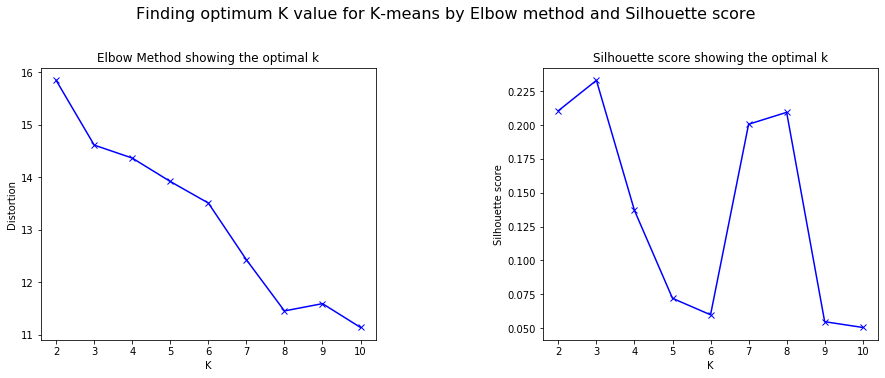

In [729]:
#plot graphs of Elbow method and Silhouette score
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(K, distortions, 'bx-')
axes[0].set(xlabel='K', ylabel='Distortion')
axes[0].set_title('Elbow Method showing the optimal k')


axes[1].plot(K, silhouette, 'bx-')
axes[1].set(xlabel='K', ylabel='Silhouette score')
axes[1].set_title('Silhouette score showing the optimal k')


fig.suptitle('Finding optimum K value for K-means by Elbow method and Silhouette score', fontsize=16, y=1.05)
fig.subplots_adjust(wspace = 0.5)

##### Observations based on above graphs:
1. Using Elbow method, we can see that local optima can be found at K=3.
2. Using Silhouette score, we got more confidence selecting K=3 as the Silhouette score is highest at that point.

Hence, we will make <b>3 clusters</b> in this process.

###### Running K-means for optimum value of K i.e. 3

In [730]:
# set number of clusters
kclusters = 3

#drop Neighbourhood column from the dataframe as it is having categorical value and holds no significance for clustering
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 1, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0])

In [731]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = df.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,2.0,Coffee Shop,Portuguese Restaurant,Pizza Place,Hockey Arena,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,2.0,Coffee Shop,Pub,Park,Bakery,Breakfast Spot,Theater,Café,Restaurant,Chocolate Shop,Distribution Center
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,2.0,Accessories Store,Clothing Store,Coffee Shop,Event Space,Sporting Goods Shop,Miscellaneous Shop,Furniture / Home Store,Arts & Crafts Store,Boutique,Women's Store
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,2.0,Coffee Shop,Sushi Restaurant,Diner,College Auditorium,Bar,Beer Bar,Spa,Sandwich Place,Burger Joint,Burrito Place


In [732]:
#Initialize map
intializeMap = folium.Figure(height=400)

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10).add_to(intializeMap)

#convert the cluster from float to int
toronto_merged.dropna(inplace=True)
toronto_merged = toronto_merged.astype({"Cluster Labels": int})

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], 
                                  toronto_merged['Longitude'], 
                                  toronto_merged['Neighbourhood'], 
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
       
map_toronto

### 3.4 Examine Clusters

#### Cluster 1

In [733]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, 
                   toronto_merged.columns[list(range(0,3)) + list(range(6, toronto_merged.shape[1]))]]

,Postcode,Borough,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,Park,Food & Drink Shop,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
21,M6E,York,Caledonia-Fairbanks,Park,Women's Store,Pool,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Discount Store
35,M4J,East York,East Toronto,Park,Convenience Store,Coffee Shop,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
49,M6L,North York,"North Park , Maple Leaf Park , Upwood Park",Park,Basketball Court,Bakery,Construction & Landscaping,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
61,M4N,Central Toronto,Lawrence Park,Park,Lawyer,Swim School,Bus Line,Yoga Studio,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
66,M2P,North York,York Mills West,Park,Bank,Convenience Store,Bar,Electronics Store,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
83,M4T,Central Toronto,"Moore Park , Summerhill East",Park,Playground,Summer Camp,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
85,M1V,Scarborough,"Milliken , Agincourt North , Steeles East , L'...",Park,Playground,Coffee Shop,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
91,M4W,Downtown Toronto,Rosedale,Park,Trail,Playground,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
98,M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North",Park,Pool,River,Smoke Shop,Concert Hall,Comfort Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant


##### Observations on Cluster 1:
1. The neighbourhoods in this cluster are having a lot of nearby outdoor places like park, trail, playground, dog run etc.
2. A good number of restaurants are also near to the neighbourhood in this cluster.

#### Cluster 2

In [734]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, 
                   toronto_merged.columns[list(range(0,3)) + list(range(6, toronto_merged.shape[1]))]]

,Postcode,Borough,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,M1B,Scarborough,"Malvern , Rouge",Fast Food Restaurant,Yoga Studio,Discount Store,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant


##### Observations on Cluster 2:
1. This cluster is having less number of neighbourhoods as compared to other clusters.
2. Most number of restaurants are nearby to the neighbourhoods in this cluster.

#### Cluster 3

In [735]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, 
                   toronto_merged.columns[list(range(0,3)) + list(range(6, toronto_merged.shape[1]))]]

,Postcode,Borough,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M4A,North York,Victoria Village,Coffee Shop,Portuguese Restaurant,Pizza Place,Hockey Arena,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",Coffee Shop,Pub,Park,Bakery,Breakfast Spot,Theater,Café,Restaurant,Chocolate Shop,Distribution Center
3,M6A,North York,"Lawrence Manor , Lawrence Heights",Accessories Store,Clothing Store,Coffee Shop,Event Space,Sporting Goods Shop,Miscellaneous Shop,Furniture / Home Store,Arts & Crafts Store,Boutique,Women's Store
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",Coffee Shop,Sushi Restaurant,Diner,College Auditorium,Bar,Beer Bar,Spa,Sandwich Place,Burger Joint,Burrito Place
7,M3B,North York,Don Mills,Japanese Restaurant,Beer Store,Gym,Restaurant,Asian Restaurant,Coffee Shop,Gym / Fitness Center,Bike Shop,Italian Restaurant,Supermarket
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,M5X,Downtown Toronto,"First Canadian Place , Underground city",Coffee Shop,Café,Restaurant,Hotel,Bar,Deli / Bodega,Gym,American Restaurant,Seafood Restaurant,Japanese Restaurant
99,M4Y,Downtown Toronto,Church and Wellesley,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Restaurant,Yoga Studio,Hotel,Mediterranean Restaurant,Men's Store,Gay Bar,Pub
100,M7Y,East Toronto,Business reply mail Processing CentrE,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Pizza Place,Restaurant
101,M8Y,Etobicoke,"Old Mill South , King's Mill Park , Sunnylea ,...",Baseball Field,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Fish & Chips Shop


##### Observations on Cluster 3:
1. The one most common venue in this cluster is Coffee shops.
2. It can be clearly noticed that the neighbourhood in this cluster are having a mix of outdoor places like playgrounds or parks, restaurants, pubs/bars, gym and clothing store. 

### Conclusion:

<b>Cluster 1</b>: If your priority is to stay near to parks, playground, trails etc.

<b>Cluster 2</b>: If your priority is to stay near to a place where you can have a lot of restaurant options.

<b>Cluster 3</b>: It is an ideal set of neighbourhoods as this cluster is having all kind of venues nearby including playgrounds, parks, restaurants, pubs/bars, malls. 